In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import warnings
import joblib
warnings.filterwarnings('ignore')

In [2]:
clusterData = pd.read_csv("data.csv")
cluster = clusterData.cluster

In [3]:
data = pd.read_csv("Medicalpremium.csv")

In [4]:
data["cluster"] = cluster

In [5]:
df = data.copy()

In [6]:
subset_selection_features = ["Age", "AnyTransplants", "AnyChronicDiseases", "HistoryOfCancerInFamily",
                             "NumberOfMajorSurgeries", "BMI"]

In [7]:
def mape(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"MAPE for data: {mape:.2f}%")

In [8]:
def eval(model, name):
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))

    mape_test = mean_absolute_percentage_error(y_test, pred_test)*100
    mape_train = mean_absolute_percentage_error(y_train, pred_train)*100

    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=cv)
    scores = np.sqrt(-scores)
    cv_mean = np.mean(scores)
    cv_std = np.std(scores)

    row = {'model': name,
           'test_rmse': rmse_test,
           'train_rmse': rmse_train,
           'test_mape': mape_test,
           'train_mape': mape_train,
           'cv_rmse': cv_mean,
           'cv_rmse_std': cv_std}
    return row

In [9]:
def upsample(x, y, cls, nSamples, category):
    sample_z = resample(z[z[category] == cls], n_samples=nSamples, replace=True, random_state=42)
    z = pd.concat([z[z[category] != cls], sample_X])
    z.reset_index(drop=True, inplace=True)

In [10]:
summary = pd.DataFrame(columns=['model',
           'test_rmse',
           'train_rmse',
           'test_mape',
           'train_mape',
           'cv_rmse',
           'cv_rmse_std'])

# Custom transformers

In [11]:
class BMI(BaseEstimator, TransformerMixin):
    def __init__(self, bmi=True, bmiCat=True, dropbmi=False):
        self.bmi = bmi
        self.bmiCat = bmiCat
        self.dropbmi = dropbmi

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.bmi:
            X["BMI"] = X["Weight"]/(X["Height"]/100)**2
            X = X.drop(["Weight", "Height"], axis=1)
            
            if self.bmiCat:
                bins = [0, 18.5, 24.9, 29.9, 34.9, 100]
                labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extreme']
                X["BMI_cat"] = pd.cut(X["BMI"], bins=bins, labels=labels, right=False)
                if self.dropbmi:
                    X = X.drop("BMI", axis=1)
                    return X
                else:
                    #X = X.drop(["Weight", "Height"], axis=1)
                    return X
            else:
                #X = X.drop(["Weight", "Height"], axis=1)
                return X
        else:
            return X

In [12]:
class cluster(BaseEstimator, TransformerMixin):
    def __init__(self, drop=True):
        self.drop = drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if (self.drop):
            X.drop("cluster", axis=1, inplace=True)
        return X

In [13]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        if (self.columns is not None):
            self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        if (self.columns is not None):
            onehot_encoded = self.encoder.transform(X[self.columns])
            feature_names = self.encoder.get_feature_names_out()
            result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
            return pd.concat([X.drop(columns=self.columns), result_df], axis=1)
        else:
            return X

In [14]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        if (self.columns is None):
            num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
            self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [15]:
class featureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if (self.columns is None):
            self.columns = X.columns
        return X[self.columns]

# preprocessing

In [16]:
#dt = upsample(category= "NumberOfMajorSurgeries", cls=3, nSamples=100).transform(df.copy())
dt = df.copy()

In [17]:
X = dt.drop("PremiumPrice", axis=1)
y = dt.PremiumPrice.copy()

In [18]:
X.shape

(986, 11)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
pipe = Pipeline([
    ('bmi', BMI(bmiCat=False)),
    ('cluster', cluster()),
    ('oneHot', oneHot()),
    ('scaler', StdScaler()),
    ('feature_selction', featureSelection())
])

In [21]:
pipe1 = clone(pipe)

In [22]:
pipe2 = clone(pipe).set_params(feature_selction__columns = subset_selection_features)

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [25]:
forest_reg = RandomForestRegressor(random_state=42, max_depth=6, n_estimators=300, n_jobs=-1, min_samples_leaf=2)

In [26]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [27]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [28]:
pred = forest_reg.predict(X_test)

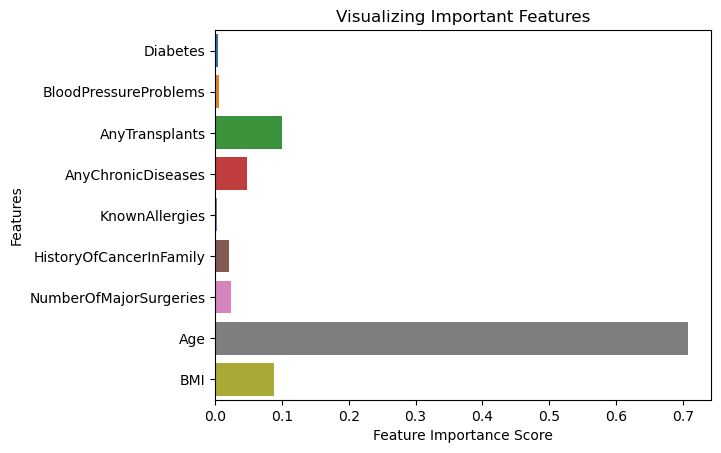

In [29]:
feature_imp1 = forest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

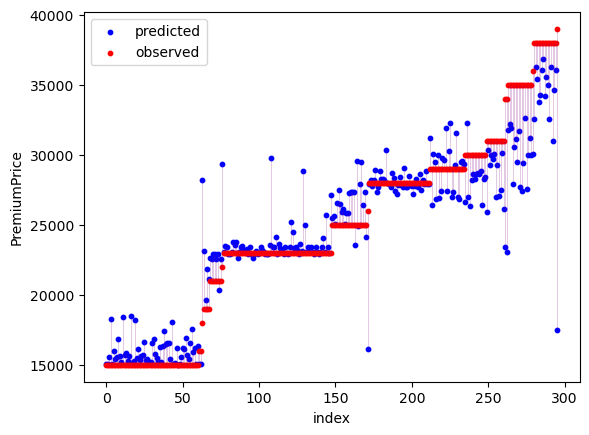

In [30]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## learning curve

In [31]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = forest_reg,
X = X_train,
y = y_train,
    cv = 5,
scoring = 'neg_mean_squared_error')

In [32]:
train_scores = np.sqrt(-train_scores)
validation_scores = np.sqrt(-validation_scores)

In [33]:
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

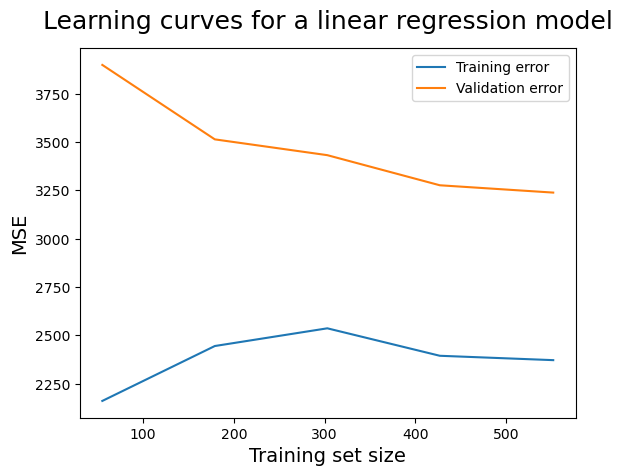

In [34]:
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

In [35]:
summary.loc[0] =eval(forest_reg, "random forset")

In [36]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3211.983204,603.617943


## feature selected

In [37]:
X_train = pipe2.fit_transform(x_train.copy())
X_test = pipe2.fit_transform(x_test.copy())

In [38]:
featured_forest_reg = RandomForestRegressor(random_state=42, max_depth=5, max_features=None, min_samples_leaf=3)

In [39]:
featured_forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=None, min_samples_leaf=3,
                      random_state=42)

In [40]:
pred = featured_forest_reg.predict(X_test)

In [41]:
eval(featured_forest_reg, 'featured_forest')

{'model': 'featured_forest',
 'test_rmse': 2922.3655123244857,
 'train_rmse': 2799.9762560080862,
 'test_mape': 7.300913005585315,
 'train_mape': 6.633588479905633,
 'cv_rmse': 3317.0067555985415,
 'cv_rmse_std': 548.3133616324752}

## hyperparameter forest

### RandomizedGridSearch

In [42]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [43]:
from sklearn.model_selection import RandomizedSearchCV

In [44]:
n_estimators = [int(i) for i in np.linspace(200, 2000, 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(i) for i in np.linspace(10, 110, 11)]
max_depth.append(None)
min_sample_split = [2, 5, 10]
min_sample_leaf = [1, 2, 4]
bootstrap = [True, False]

In [45]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_sample_split,
               'min_samples_leaf': min_sample_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [46]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [47]:
forest_reg = RandomForestRegressor(random_state=42)

In [48]:
forest_rgrid = RandomizedSearchCV(estimator=forest_reg,
                                  param_distributions=random_grid,
                                  cv=3,
                                  verbose=2,
                                  random_state=42,
                                  n_jobs=-1,
                                  scoring='neg_mean_squared_error',
                                  return_train_score=True,
                                  n_iter=100)

In [ ]:
score = forest_rgrid.fit(X_train, y_train)

#### saving

In [ ]:
#joblib.dump(score, "forest1.pkl")
#score = joblib.load("forest1.pkl")

In [ ]:
score.best_params_

In [ ]:
cvres = score.cv_results_

temp = pd.DataFrame(cvres['params'])
temp["rmse"] = np.sqrt(-cvres["mean_test_score"])
temp.sort_values("rmse").head(20)

In [ ]:
best_forest_rgrid = score.best_estimator_

In [ ]:
pred = best_forest_rgrid.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, pred))

In [ ]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [ ]:
pred = best_forest_rgrid.predict(X_train)
np.sqrt(mean_squared_error(y_train, pred))

### GridSearch

In [465]:
from sklearn.model_selection import GridSearchCV

In [466]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [467]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [4, 5, 6],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 300, 500]
}

In [468]:
forest_reg2 = RandomForestRegressor(random_state=42)

In [469]:
forest_grid = GridSearchCV(estimator = forest_reg2, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [470]:
score = forest_grid.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


#### saving

In [471]:
#joblib.dump(score, "forest2.pkl")
#score = joblib.load("forest2.pkl")

In [472]:
best_forest_grid = score.best_estimator_

In [473]:
score.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 2,
 'n_estimators': 300}

In [474]:
best_forest_grid

RandomForestRegressor(max_depth=6, max_features=None, min_samples_leaf=2,
                      n_estimators=300, random_state=42)

In [475]:
pred = best_forest_grid.predict(X_test)

In [476]:
np.sqrt(mean_squared_error(y_test, pred))

2759.181477662577

In [483]:
# train rmse
np.sqrt(mean_squared_error(y_train, best_forest_grid.predict(X_train)))

2412.6587065737413

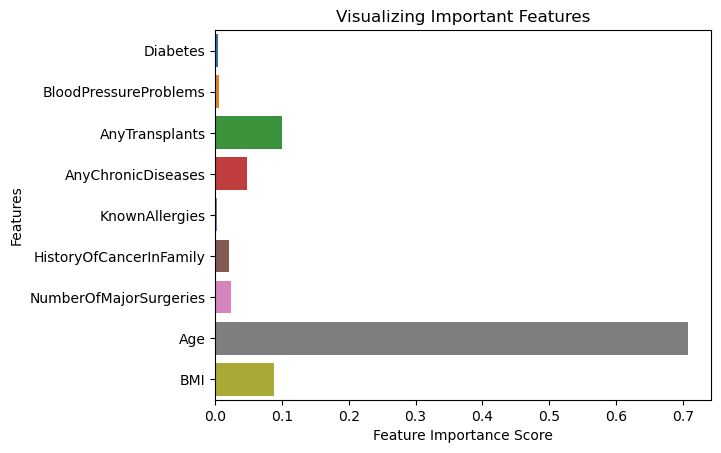

In [477]:
feature_imp1 = best_forest_grid.feature_importances_


sns.barplot(x=feature_imp1, y=X_test.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

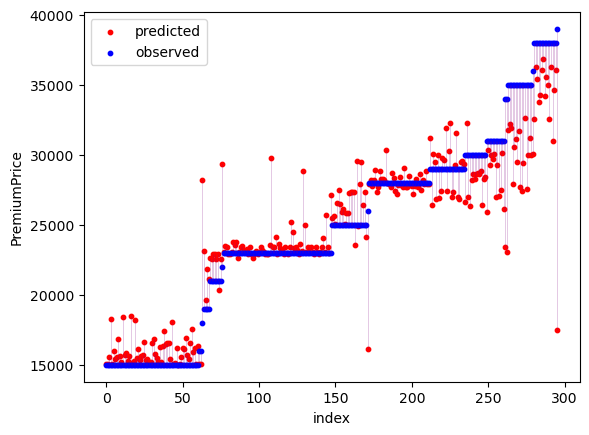

In [478]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [481]:
forest_cv = cross_val_score(score.best_estimator_, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [482]:
forest_rmse = np.sqrt(-forest_cv)
display_scores(forest_rmse)

Scores: [3443.98969946 3596.59581388 3399.48993602 3615.6123242  4133.26209702
 3798.45045256 1956.56458302 2200.89268574 2265.9477664  3623.09767881]
Mean: 3203.390303711799
Standard deviation: 724.8563635965833


# Deision tree

In [49]:
from sklearn.tree import DecisionTreeRegressor

In [50]:
tree_reg = DecisionTreeRegressor(max_depth=6, random_state=42, min_samples_leaf=2, max_features=None)

In [51]:
tree_reg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [52]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [53]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=2, random_state=42)

In [54]:
pred = tree_reg.predict(X_test)

In [55]:
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=42)
for depth in range (1,10):
     tree_regressor=DecisionTreeRegressor(max_depth=depth,random_state=42, min_samples_leaf=2)
     if tree_regressor.fit(X_train,y_train).tree_.max_depth<depth:
         break
     score=np.mean(cross_val_score(tree_regressor,X_train,y_train,scoring='neg_mean_squared_error', cv=crossvalidation,n_jobs=1))
     print(depth, np.sqrt(-score))

1 4335.112021947933
2 4107.961626941019
3 3683.6339078824853
4 3601.2710609094875
5 3674.3213931460223
6 3534.4762095979872
7 3659.532331437254
8 3779.71190876779
9 3835.717644801662


In [56]:
summary.loc[1] = eval(tree_reg, "Decision tree")

In [57]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3211.983204,603.617943
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543


# KNN

In [58]:
from sklearn.neighbors import KNeighborsRegressor

In [59]:
knn = KNeighborsRegressor(n_jobs=-1)

In [60]:
knn.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [61]:
eval(knn, "KNN")

{'model': 'KNN',
 'test_rmse': 4134.675385147006,
 'train_rmse': 3234.7748168832445,
 'test_mape': 9.876663583807796,
 'train_mape': 8.01568793755444,
 'cv_rmse': 3973.0332913362718,
 'cv_rmse_std': 446.0364277939395}

# AdaBoost

In [62]:
from sklearn.ensemble import AdaBoostRegressor

In [63]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [64]:
Dtree = DecisionTreeRegressor(max_depth=6, random_state=42)
ada_boost = AdaBoostRegressor(n_estimators=200, base_estimator=tree_reg, learning_rate=0.001, random_state=42)

In [65]:
ada_boost

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6,
                                                       min_samples_leaf=2,
                                                       random_state=42),
                  learning_rate=0.001, n_estimators=200, random_state=42)

In [66]:
ada_boost.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6,
                                                       min_samples_leaf=2,
                                                       random_state=42),
                  learning_rate=0.001, n_estimators=200, random_state=42)

In [67]:
pred = ada_boost.predict(X_test)

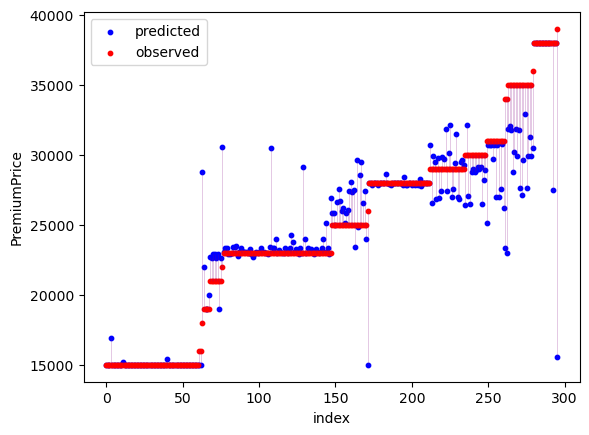

In [68]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [69]:
summary.loc[2] = eval(ada_boost, "AdaBoost")
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3211.983204,603.617943
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543
2,AdaBoost,2695.114327,2278.660585,4.234093,3.602639,3218.553748,597.505380


# XGBoost


In [70]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [71]:
xg_boost = xgb.XGBRegressor(max_depth=5, random_state=42, colsample_bytree=0.5, subsample=0.5, eta=0.1)

In [72]:
xg_boost.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.1}

In [73]:
xg_boost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [74]:
pred = xg_boost.predict(X_test)

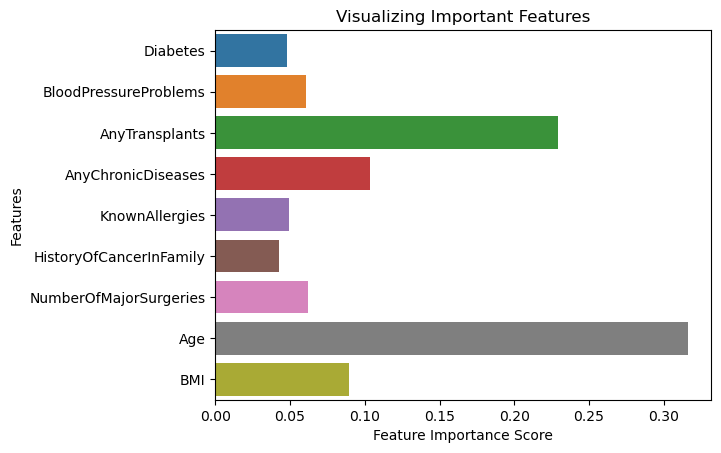

In [75]:
feature_imp1 = xg_boost.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.savefig('my_plot.png')
plt.show()

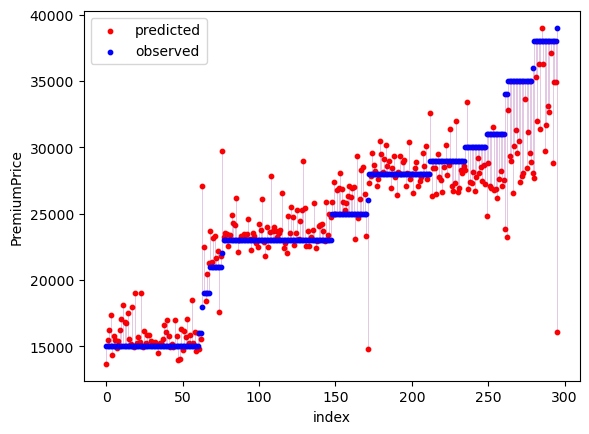

In [76]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [77]:
summary.loc[3] = eval(xg_boost, "XGBoost")
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3211.983204,603.617943
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543
2,AdaBoost,2695.114327,2278.660585,4.234093,3.602639,3218.553748,597.505380
3,XGBoost,3122.064487,2166.599023,7.540181,5.434179,3534.844505,502.168099


# Stacking

## attempt1

In [78]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [79]:
from sklearn.model_selection import RepeatedKFold

In [80]:
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 return models

In [81]:
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
 return np.sqrt(-scores)

In [82]:
models = get_models()

>knn 4255.198 (579.644)
>cart 3884.027 (954.983)
>svm 6359.471 (513.949)


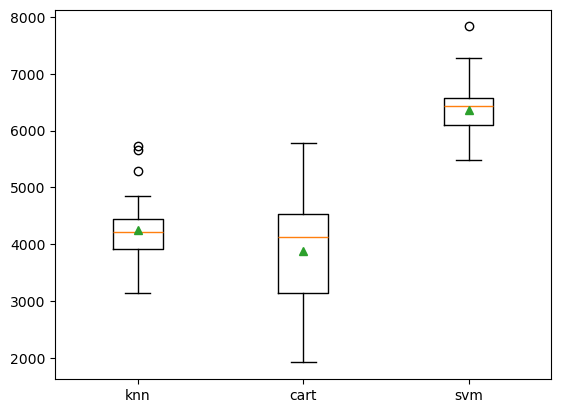

In [83]:
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [84]:
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 models['stacking'] = get_stacking()
 return models

In [85]:
def get_stacking():
 # define the base models
 level0 = list()
 level0.append(('knn', KNeighborsRegressor()))
 level0.append(('cart', DecisionTreeRegressor()))
 level0.append(('svm', SVR()))
 # define meta learner model
 level1 = LinearRegression()
 # define the stacking ensemble
 model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
 return model

>knn 3988.537 (594.969)
>cart 4547.618 (961.248)
>svm 6132.304 (462.552)
>stacking 3773.176 (680.530)


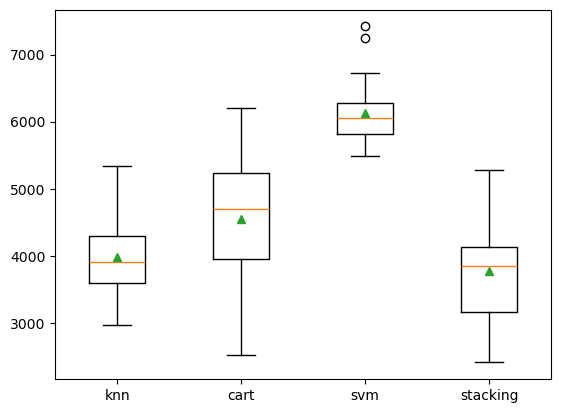

In [86]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## attempt2

In [87]:
level0 = list()
level0.append(('forest', RandomForestRegressor(random_state=42)))
level0.append(('xgboost', xgb.XGBRegressor()))

level1 = LinearRegression()

stacked_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

In [88]:
models = dict()
models["forest"] = RandomForestRegressor(random_state=42)
models["xgboost"] = xgb.XGBRegressor()
models["stacking"] = stacked_model

In [89]:
models

{'forest': RandomForestRegressor(random_state=42),
 'xgboost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...),
 'stacking': StackingRegressor(cv=5,
                   estimators=[('forest',
                                RandomForestRegressor(random_state=42)),
                               ('

>forest 3410.852 (732.343)
>xgboost 3695.487 (719.970)
>stacking 3409.276 (700.973)


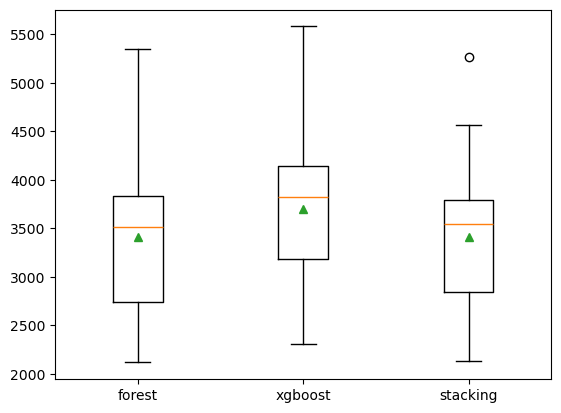

In [90]:
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## attemp3

In [91]:
level0 = list()
level0.append(('forest', forest_reg))
level0.append(('adaboost', ada_boost))

level1 = LinearRegression()

stacked_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

In [92]:
models = dict()
models["forest"] = forest_reg
models['adaboost'] = ada_boost
models["stacking"] = stacked_model

>forest 3410.852 (732.343)
>adaboost 3149.627 (866.340)
>stacking 3138.479 (794.062)


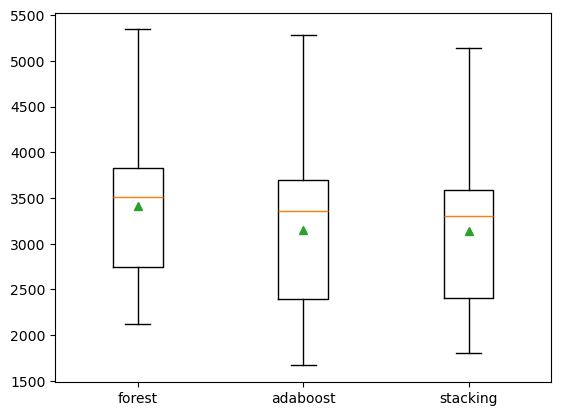

In [93]:
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# Cluster wise model fitting

In [94]:
dq = pd.read_csv("data.csv")

In [95]:
dq.drop(["BMI", "BMI_cat"], axis=1, inplace=True)

In [96]:
cluster1 = dq[dq.cluster == 1]
cluster2 = dq[dq.cluster == 2]
cluster3 = dq[dq.cluster == 3]

## cluster1

3528.449786341991
895.4240395065992


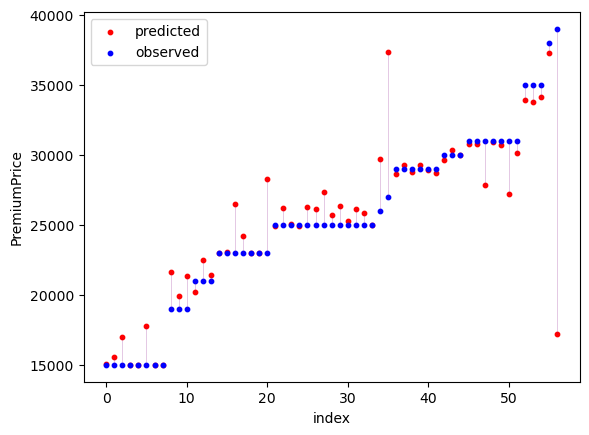

In [74]:
X_c1 = cluster1.drop("PremiumPrice", axis=1)
y_c1 = cluster1.PremiumPrice
X_c1_train, X_c1_test, y_c1_train, y_c1_test = train_test_split(X_c1, y_c1, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_c1_train, y_c1_train)

pred_c1_test = forest_reg.predict(X_c1_test)

print(np.sqrt(mean_squared_error(y_c1_test, pred_c1_test)))

#train rmse
pred_c1_train = forest_reg.predict(X_c1_train)
print(np.sqrt(mean_squared_error(y_c1_train, pred_c1_train)))


temp = pd.DataFrame({'Observed':y_c1_test, 'predicted':pred_c1_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [75]:
scores = cross_val_score(forest_reg, X_c1_train, y_c1_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [3231.63035984 3022.75788269 2224.49505751 1340.55634136 3031.35139902
 3424.72340997 1308.46408467 1185.08117499 1931.15250563 2484.88979086]
Mean: 2318.5102006526
Standard deviation: 806.8096878414024


## cluster2

4989.134729242603
929.0640451551228


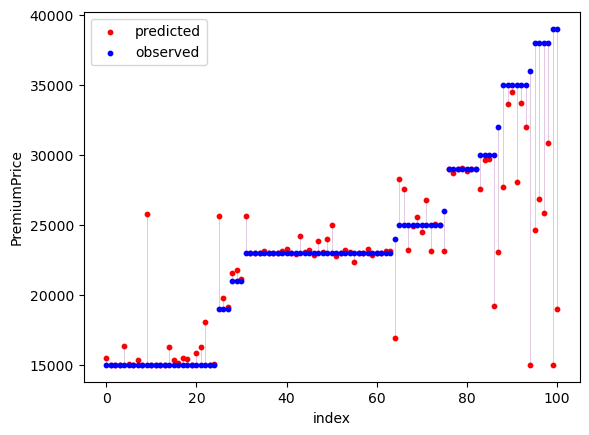

In [76]:
X_c2 = cluster2.drop("PremiumPrice", axis=1)
y_c2 = cluster2.PremiumPrice
X_c2_train, X_c2_test, y_c2_train, y_c2_test = train_test_split(X_c2, y_c2, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_c2_train, y_c2_train)

pred_c2_test = forest_reg.predict(X_c2_test)

print(np.sqrt(mean_squared_error(y_c2_test, pred_c2_test)))

#train rmse
pred_c2_train = forest_reg.predict(X_c2_train)
print(np.sqrt(mean_squared_error(y_c2_train, pred_c2_train)))

temp = pd.DataFrame({'Observed':y_c2_test, 'predicted':pred_c2_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [77]:
scores = cross_val_score(forest_reg, X_c2_train, y_c2_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [2543.81603108 3987.41990515 1823.00164564 2171.16731276 3897.96357089
 1081.65729323 4017.35671804 3378.48264758 3458.47654322 2332.75748847]
Mean: 2869.2099156066834
Standard deviation: 969.762063696187


## cluster3

1610.9554618300283
766.6648550703234


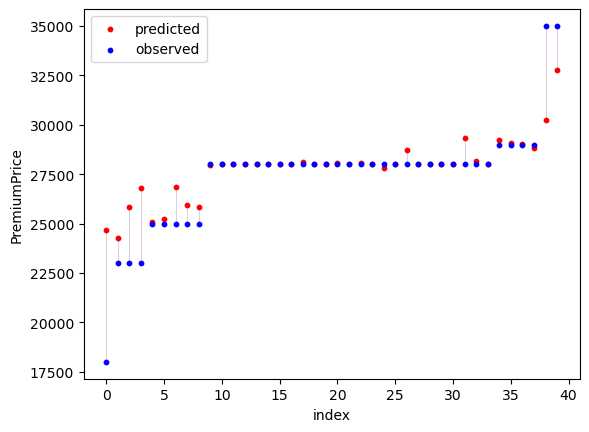

In [78]:
X_c3 = cluster3.drop("PremiumPrice", axis=1)
y_c3 = cluster3.PremiumPrice
X_c3_train, X_c3_test, y_c3_train, y_c3_test = train_test_split(X_c3, y_c3, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_c3_train, y_c3_train)

pred_c3_test = forest_reg.predict(X_c3_test)

print(np.sqrt(mean_squared_error(y_c3_test, pred_c3_test)))

# train rmse
pred_c3_train = forest_reg.predict(X_c3_train)
print(np.sqrt(mean_squared_error(y_c3_train, pred_c3_train)))

temp = pd.DataFrame({'Observed':y_c3_test, 'predicted':pred_c3_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [79]:
scores = cross_val_score(forest_reg, X_c3_train, y_c3_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [ 260.43233286 2563.38033659 1562.74998    1402.98565566 2599.50956913
 1932.68272099 1953.8871513  1533.95730058 3211.49303284 1033.55273208]
Mean: 1805.4630812036557
Standard deviation: 806.0807573752162


In [80]:
y_c1_test.shape + y_c2_test.shape + y_c3_test.shape

(57, 101, 40)

In [81]:
dfc1 = pd.DataFrame({'test_observed':y_c1_test,
              'test_predicted':pred_c1_test})
dfc1.reset_index(drop=True, inplace=True)

dfc2 = pd.DataFrame({'test_observed':y_c2_test,
              'test_predicted':pred_c2_test})
dfc2.reset_index(drop=True, inplace=True)

dfc3 = pd.DataFrame({'test_observed':y_c3_test,
              'test_predicted':pred_c3_test})
dfc3.reset_index(drop=True, inplace=True)

dfc = pd.concat([dfc1, dfc2, dfc3])

In [82]:
np.sqrt(mean_squared_error(dfc.test_observed, dfc.test_predicted))

4099.453461971326

# Adding cluster label

In [97]:
pipec = clone(pipe).set_params(**{'cluster__drop': False,
                                 'oneHot__columns': ["cluster"]})

In [98]:
X_train = pipec.fit_transform(x_train.copy())
X_test = pipec.fit_transform(x_test.copy())

## Random Forest

In [99]:
nforest_reg = RandomForestRegressor(max_depth=6, n_estimators=300, min_samples_leaf=2, random_state=42, n_jobs=-1)

In [100]:
nforest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [101]:
pred = nforest_reg.predict(X_test)

In [102]:
eval(nforest_reg, 'random forest2')

{'model': 'random forest2',
 'test_rmse': 2770.993660434782,
 'train_rmse': 2414.251008674677,
 'test_mape': 6.300340029634524,
 'train_mape': 5.333386417503949,
 'cv_rmse': 3219.179445729342,
 'cv_rmse_std': 603.8355840841236}

In [103]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3211.983204,603.617943
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543
2,AdaBoost,2695.114327,2278.660585,4.234093,3.602639,3218.553748,597.505380
3,XGBoost,3122.064487,2166.599023,7.540181,5.434179,3534.844505,502.168099


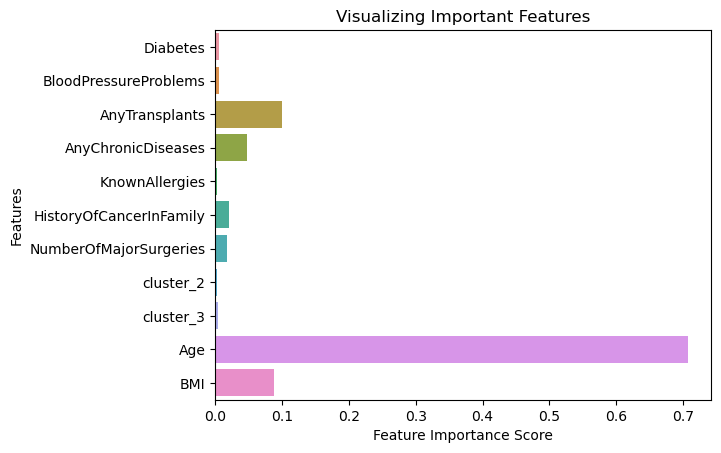

In [104]:
feature_imp1 = nforest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

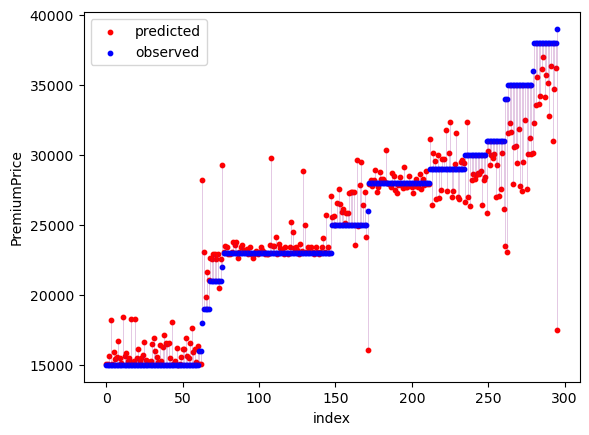

In [105]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## xgboost

In [106]:
nxgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=5, eta=0.01,
                         subsample=0.5, colsample_bytree=0.5, gamma=0)

In [107]:
nxgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [108]:
pred = nxgb_reg.predict(X_test)

In [109]:
eval(nxgb_reg, "xgboost2")

{'model': 'xgboost2',
 'test_rmse': 3022.0096844733903,
 'train_rmse': 2031.0671680245587,
 'test_mape': 7.422968854404307,
 'train_mape': 5.2440409521101214,
 'cv_rmse': 3421.557832359923,
 'cv_rmse_std': 476.3193915899515}

In [110]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3211.983204,603.617943
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543
2,AdaBoost,2695.114327,2278.660585,4.234093,3.602639,3218.553748,597.505380
3,XGBoost,3122.064487,2166.599023,7.540181,5.434179,3534.844505,502.168099


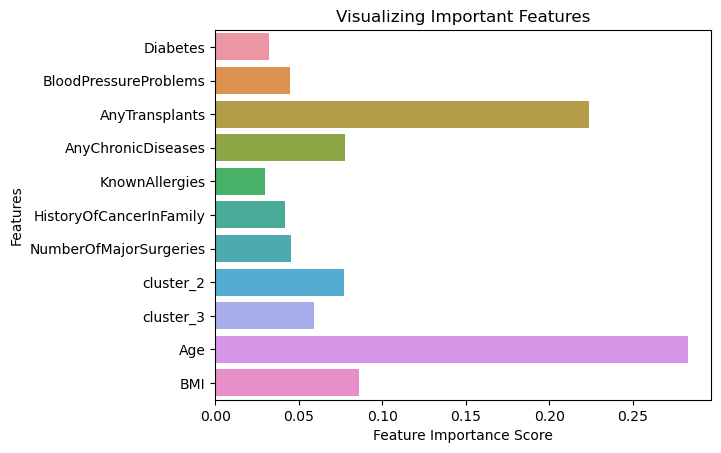

In [111]:
feature_imp1 = nxgb_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

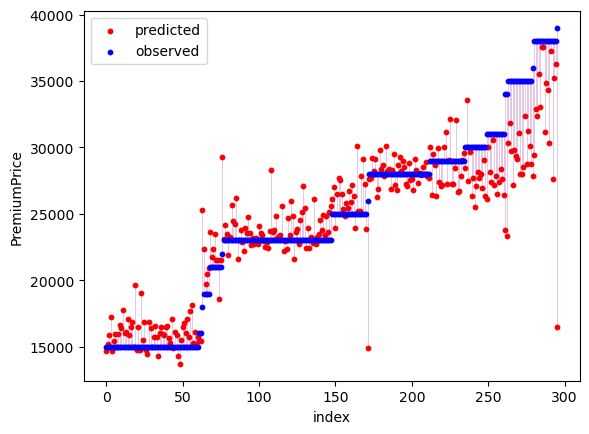

In [112]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## AdaBoost

In [113]:
nada_boost = AdaBoostRegressor(n_estimators=200, base_estimator=tree_reg, learning_rate=0.001, random_state=42)

In [114]:
nada_boost.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6,
                                                       min_samples_leaf=2,
                                                       random_state=42),
                  learning_rate=0.001, n_estimators=200, random_state=42)

In [115]:
eval(nada_boost, "adaboost")

{'model': 'adaboost',
 'test_rmse': 2701.5758776957737,
 'train_rmse': 2292.077333161312,
 'test_mape': 4.238417624445258,
 'train_mape': 3.6111605391650494,
 'cv_rmse': 3234.6035736414406,
 'cv_rmse_std': 592.0108441858846}

In [116]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3211.983204,603.617943
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543
2,AdaBoost,2695.114327,2278.660585,4.234093,3.602639,3218.553748,597.505380
3,XGBoost,3122.064487,2166.599023,7.540181,5.434179,3534.844505,502.168099


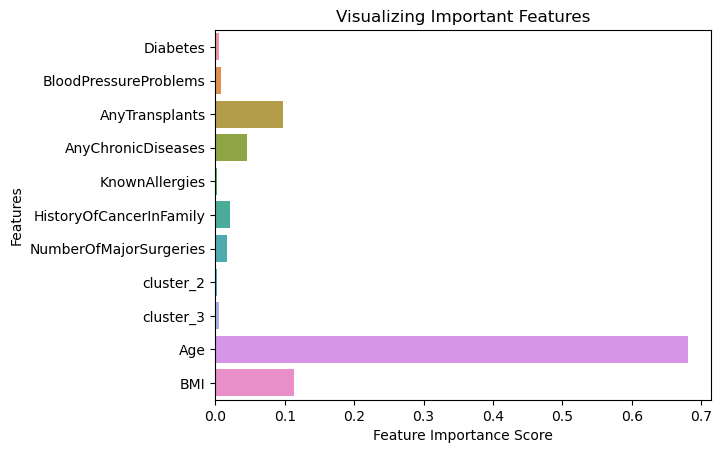

In [117]:
feature_imp1 = nada_boost.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# Factor Analysis Components Regression

In [118]:
fct = pd.read_csv("factor.csv")

In [102]:
X = fct.copy()

In [103]:
y = df.PremiumPrice.copy()

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## Random forest

In [105]:
forest_reg = RandomForestRegressor()

In [106]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [107]:
pred = forest_reg.predict(X_test)

In [108]:
np.sqrt(mean_squared_error(y_test, pred))

3486.747203427008

In [109]:
scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

In [110]:
scores = np.sqrt(-scores)

In [111]:
display_scores(scores)

Scores: [4199.09061885 3812.35632641 3556.15921388 4153.50103961 3596.28394706
 4207.78106833 4154.22661084 3569.86862858 2805.78111981 3928.45405752]
Mean: 3798.3502630881585
Standard deviation: 416.5350279371173


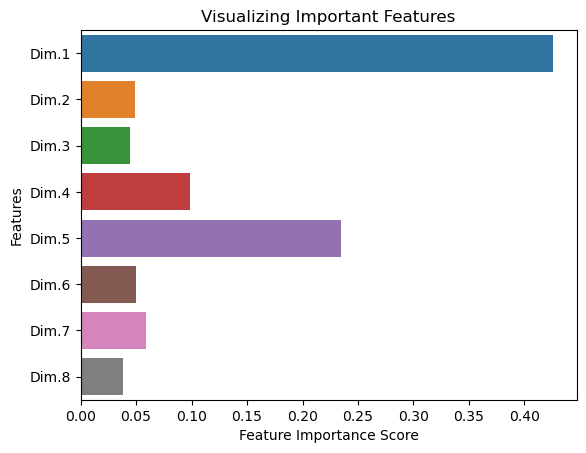

In [112]:
feature_imp1 = forest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

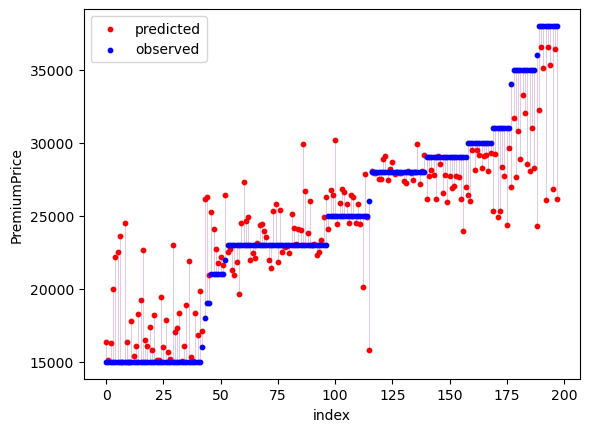

In [113]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## XGBoost

In [114]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1,
                         subsample=0.7, colsample_bytree=0.8)

In [115]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [116]:
pred = xgb_reg.predict(X_test)

In [117]:
np.sqrt(mean_squared_error(y_test, pred))

3514.1452270275063

In [118]:
scores = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

In [119]:
scores = np.sqrt(-scores)

In [120]:
display_scores(scores)

Scores: [4662.22691682 3893.09128372 4118.28264508 4105.64214189 3601.5863421
 4378.97024244 4203.16461578 3637.87452119 3081.34424207 3960.65136234]
Mean: 3964.283431343744
Standard deviation: 422.2093798464794


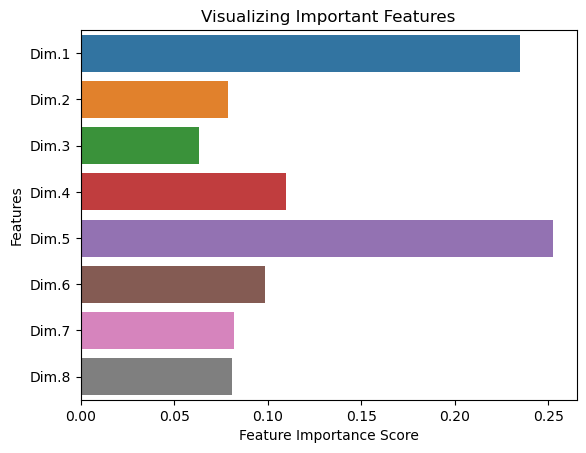

In [121]:
feature_imp1 = xgb_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

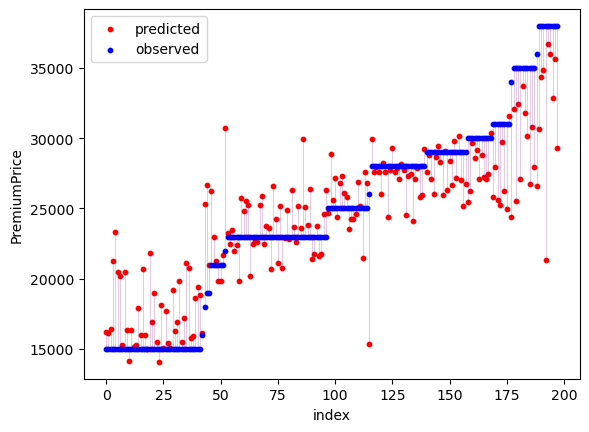

In [122]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

# upsampled

# experiment

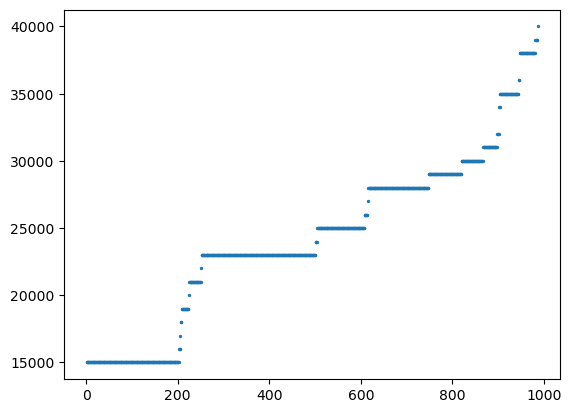

In [137]:
temp = dq.PremiumPrice.sort_values()
plt.scatter(np.arange(1, len(temp) + 1, 1), temp, s=2)

In [138]:
np.unique(df.PremiumPrice)

array([15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000,
       24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000,
       34000, 35000, 36000, 38000, 39000, 40000], dtype=int64)

In [139]:
len(np.unique(df.PremiumPrice))

24

In [152]:
def outlierDetection(column_name, tbl):
    Q1 = tbl[column_name].quantile(0.25)
    Q3 = tbl[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (tbl[column_name] < lower_bound) | (tbl[column_name] > upper_bound)
    outlier_indices = tbl.index[outliers]
    return outlier_indices

In [164]:
outlierDetection('PremiumPrice', dt)

Index([  7,  12,  14,  19,  21,  26,  30,  32,  33,  38,
       ...
       949, 953, 956, 958, 961, 964, 965, 966, 968, 969],
      dtype='int64', length=244)

In [156]:
outlierDetection('Age', df)

Index([], dtype='int64')

In [159]:
outlierDetection('BMI', X_train)

Index([756,  97, 155, 172,  24, 222, 180, 225,  26, 151, 183, 206, 779, 200,
       201, 189, 130],
      dtype='int64')

In [49]:
tf = ColumnTransformer([
    ('targetenc', TargetEncoder(categories='auto', smooth='auto', target_type="continuous"), ["NumberOfMajorSurgeries"])
])

In [52]:
temp = tf.fit_transform(X_train.copy(), y_train.copy())

In [53]:
np.unique(temp)

array([22581.4195302 , 22955.93872023, 23064.5372572 , 23081.6061072 ,
       23101.81934862, 24022.01373298, 24457.49172855, 24601.9060784 ,
       24822.10526771, 24927.06659167, 27972.62327636, 28000.        ,
       28100.1192746 , 28128.63204563, 28130.19383107, 28179.32947531])

In [42]:
temp_forest = RandomForestRegressor()

In [43]:
temp_forest.fit(temp, y_train)

RandomForestRegressor()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


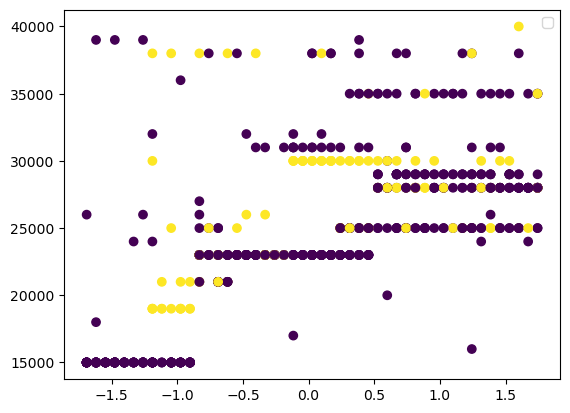

In [234]:
fig = plt.figure()
plt.scatter(X_train.Age, y_train, c=X_train.AnyChronicDiseases)
plt.legend()
plt.show()

In [219]:
temp = X_train[y_train == 35000]

In [223]:
temp.describe()

,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,Age,BMI
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.320000,0.440000,0.080000,0.120000,0.160000,0.080000,0.480000,0.991071,1.146728
std,0.476095,0.506623,0.276887,0.331662,0.374166,0.276887,0.509902,0.479747,1.139123
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.312543,-1.596385
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.527267,0.486093
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.956716,1.156204
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.386164,1.617081
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.744038,3.838879


In [224]:
temp = X_train[y_train == 25000]

In [226]:
temp.describe()

,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,Age,BMI
count,80.000000,80.00000,80.0,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,0.500000,0.66250,0.0,0.250000,0.212500,0.212500,0.575000,0.721414,-0.707714
std,0.503155,0.47584,0.0,0.435745,0.411658,0.411658,0.497462,0.646954,0.663969
min,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,-1.047377,-1.875396
25%,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.312543,-1.135674
50%,0.500000,1.00000,0.0,0.000000,0.000000,0.000000,1.000000,0.741991,-0.774665
75%,1.000000,1.00000,0.0,0.250000,0.000000,0.000000,1.000000,1.243014,-0.486666
max,1.000000,1.00000,0.0,1.000000,1.000000,1.000000,1.000000,1.744038,1.453362
